In [33]:
import seaborn as sns
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import ppscore as pps
import datetime
import ppscore as pps
import random
from torchsummary import summary
import bokeh
from bokeh.plotting import figure, show
pd.set_option("display.max_columns",80)
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.set_option("display.max_rows",80)
import tslumen
import tqdm as notebook_tqdm
import datetime as dt
from tslumen import HtmlReport
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import tqdm as notebook_tqdm
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



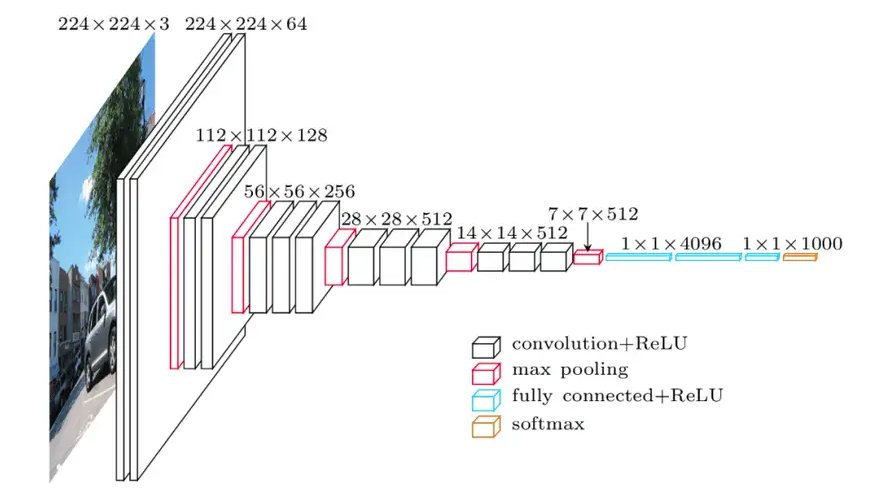

In [45]:
a = ["A",1,"B",2]
print(a)
print(*a)

['A', 1, 'B', 2]
A 1 B 2


In [70]:
# Smarted Implementation of VGG16/19
def make_vgg_layer(in_channels,out_channels,num_convs,pool = True):
    layers = []
    for ind in range(num_convs):
        layers.append(nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,padding=1))
        layers.append(nn.ReLU(inplace = True))
        # Change in channels to out channels
        in_channels = out_channels
    if pool:
        layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    
    return nn.Sequential(*layers)

In [74]:
def make_vgg16_block_2(in_channels,mid_channels,out_channels):
    return [nn.Conv2d(in_channels=in_channels,out_channels=mid_channels,kernel_size=3,padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=mid_channels,out_channels=out_channels,kernel_size=3,padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2,2)]
    
class VGG16Implementation(nn.Module):
    def __init__(self,num_classes):
        super(VGG16Implementation,self).__init__()
        self.features = nn.Sequential(*make_vgg_layer(3,64,2),
                                      *make_vgg_layer(64,128,2),
                                      *make_vgg_layer(128,256,3),
                                      *make_vgg_layer(256,512,3),
                                      *make_vgg_layer(512,512,3))

        self.classifier = nn.Sequential(nn.Linear(512*7*7,4096),nn.ReLU(inplace=True),
                          nn.Dropout(),nn.Linear(4096,4096),nn.ReLU(),
                          nn.Dropout(),nn.Linear(4096,num_classes))

    def forward(self,x):
        x = self.features(x)
        print(f"X_size {x.size()}") # Output size after convolution operations

        x = x.view(x.size(0),-1)
        print(f"X_size {x.size()}") # Output size after flattening

        x = self.classifier(x) # Classifier
        return x



In [75]:
vgg = VGG16Implementation(num_classes = 5)
vgg.to(device)


VGG16Implementation(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, paddi

In [76]:
summary(vgg, (3,224, 224))


X_size torch.Size([2, 512, 7, 7])
X_size torch.Size([2, 25088])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256,